### 计算输出1

In [22]:
import pandas as pd
import numpy as np

# 假设df已生成

a_orig_list = sorted(df['A_orig'].unique())
a_list = [df[df['A_orig']==a]['A'].iloc[0] for a in a_orig_list]
b_orig_list = sorted(df['B_orig'].unique(), reverse=True)

# 先用pivot_table快速生成二维表
pivot = df.pivot(index='B_orig', columns='A_orig', values='target')
b_map = df.drop_duplicates('B_orig').set_index('B_orig')['B']

# 构造最终输出
header1 = ['', '', 'A_orig'] + [str(a) for a in a_orig_list]
header2 = ['B_orig', 'B', 'A'] + [str(a) for a in a_list]
data_rows = []

for b in b_orig_list:
    row = [b, b_map[b], '']
    row += [pivot.loc[b, a] if a in pivot.columns else np.nan for a in a_orig_list]
    data_rows.append(row)

all_rows = [header1, header2] + data_rows

pd.DataFrame(all_rows).to_csv('output.csv', header=False, index=False, encoding='utf-8-sig')

### 计算输出2

In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 假设df已生成

# 按B_orig分组，对A_orig排序后对target做diff
df_sorted = df.sort_values(['B_orig', 'A_orig'])
df_sorted['target_diff'] = df_sorted.groupby('B_orig')['target'].diff()

a_orig_list = sorted(df_sorted['A_orig'].unique())
a_list = [df_sorted[df_sorted['A_orig']==a]['A'].iloc[0] for a in a_orig_list]
b_orig_list = sorted(df_sorted['B_orig'].unique(), reverse=True)

pivot = df_sorted.pivot(index='B_orig', columns='A_orig', values='target_diff')
b_map = df_sorted.drop_duplicates('B_orig').set_index('B_orig')['B']

header1 = ['', '', 'A_orig'] + [str(a) for a in a_orig_list]
header2 = ['B_orig', 'B', 'A'] + [str(a) for a in a_list]
data_rows = []

for b in tqdm(b_orig_list, desc="生成数据行"):
    row = [b, b_map[b], '']
    row += [pivot.loc[b, a] if a in pivot.columns else np.nan for a in a_orig_list]
    data_rows.append(row)

all_rows = [header1, header2] + data_rows

pd.DataFrame(all_rows).to_csv('output2.csv', header=False, index=False, encoding='utf-8-sig')

生成数据行: 100%|██████████| 800/800 [00:35<00:00, 22.77it/s]


### 计算输出3

In [31]:
import pandas as pd
import numpy as np

# 生成坐标点
x = np.arange(0, 8000)
y = np.arange(0, 800)
xx, yy = np.meshgrid(x, y)
A = xx.ravel()
B = yy.ravel()
A_orig = A - 5
B_orig = B - 6
target = A + B

df = pd.DataFrame({
    'A': A,
    'A_orig': A_orig,
    'B': B,
    'B_orig': B_orig,
    'target': target
})

# x分区：2-1-1-1-1-1-1-2，总长8000
x_bins = [0, 2000, 3000, 4000, 5000, 6000, 7000,7500, 8000]
# y分区：3-1-1-2，总长800，应该是[0, 600, 700, 800]，但要4段，需要5个点
y_bins = [0, 200, 600, 700, 800]  # 3:200, 1:400, 1:100, 2:100

# 检查分区数量
assert len(x_bins) == 8 + 1
assert len(y_bins) == 4 + 1

df['A_bin'] = pd.cut(df['A'], bins=x_bins, labels=False, right=False, include_lowest=True)
df['B_bin'] = pd.cut(df['B'], bins=y_bins, labels=False, right=False, include_lowest=True)

df['label'] = df['B_bin'] * 8 + df['A_bin'] + 1

print(df[['A', 'B', 'A_bin', 'B_bin', 'label']].head(10))
print(df['label'].value_counts().sort_index())
print('label种类数:', df['label'].nunique())

   A  B  A_bin  B_bin  label
0  0  0      0      0      1
1  1  0      0      0      1
2  2  0      0      0      1
3  3  0      0      0      1
4  4  0      0      0      1
5  5  0      0      0      1
6  6  0      0      0      1
7  7  0      0      0      1
8  8  0      0      0      1
9  9  0      0      0      1
label
1     400000
2     200000
3     200000
4     200000
5     200000
6     200000
7     100000
8     100000
9     800000
10    400000
11    400000
12    400000
13    400000
14    400000
15    200000
16    200000
17    200000
18    100000
19    100000
20    100000
21    100000
22    100000
23     50000
24     50000
25    200000
26    100000
27    100000
28    100000
29    100000
30    100000
31     50000
32     50000
Name: count, dtype: int64
label种类数: 32


x方向采样点数: 80
y方向采样点数: 40
采样点总数: 3200


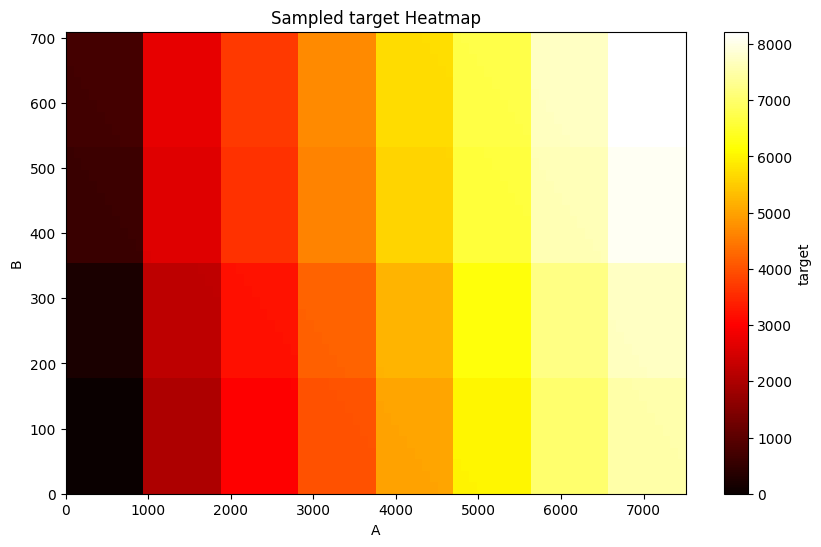

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设df已存在，且有A, B, target, label等列

# 1. x方向采样：每个A_bin区间内不超过10个不同A
sampled_x = (
    df.groupby('A_bin')['A']
    .unique()
    .apply(lambda arr: np.sort(arr)[:10])
)
sampled_x = np.unique(np.concatenate(sampled_x.values))
print(f"x方向采样点数: {len(sampled_x)}")

# 2. y方向采样：每个B_bin区间内不超过10个不同B
sampled_y = (
    df.groupby('B_bin')['B']
    .unique()
    .apply(lambda arr: np.sort(arr)[:10])
)
sampled_y = np.unique(np.concatenate(sampled_y.values))
print(f"y方向采样点数: {len(sampled_y)}")

# 3. 采样点的笛卡尔积
sample_points = pd.DataFrame([(x, y) for x in sampled_x for y in sampled_y], columns=['A', 'B'])

# 4. 合并target
sample_points = sample_points.merge(df[['A', 'B', 'target']], on=['A', 'B'], how='left')

print(f"采样点总数: {len(sample_points)}")

# 5. 画热力图
pivot = sample_points.pivot(index='B', columns='A', values='target')
plt.figure(figsize=(10, 6))
# plt.imshow(pivot, aspect='auto', origin='lower', cmap='hot')
plt.imshow(
    pivot,
    aspect='auto',
    origin='lower',
    cmap='hot',
    extent=[
        pivot.columns.min(), pivot.columns.max(),
        pivot.index.min(), pivot.index.max()
    ]
)
plt.colorbar(label='target')
plt.xlabel('A')
plt.ylabel('B')
plt.title('Sampled target Heatmap')
plt.show()